# Two-Layer SWM diagnostics
The script is for compring the impacts of number of meridionally oriented ridges in a model forced with surface wind stress.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dask
import dask.distributed
from xgcm import Grid
%matplotlib inline

Specify cases and the main path

In [24]:
n_ridge = [1, 2, 3, 5, 7, 10, 15, 20]
ppdir = "/work/Hemant.Khatri/MOM6_idealised/SWM_Two_Layer/sin_ridge/H_500/"

# Time series of energy

In [25]:
# Read stats file for energy time series
dataset = []
for i in range(0, len(n_ridge)):
    d = xr.open_dataset(ppdir+"H_500_n_"+str(n_ridge[i])+"/ocean.stats.nc") 
    dataset.append(d)
ds = xr.concat(dataset, dim='nr')

In [26]:
ds

<xarray.Dataset>
Dimensions:        (Interface: 3, Layer: 2, Time: 1826, nr: 8)
Coordinates:
  * Layer          (Layer) float64 1.027e+03 1.028e+03
  * Time           (Time) timedelta64[ns] 0 days 10 days ... 18250 days
  * Interface      (Interface) float64 1.027e+03 1.028e+03 1.028e+03
Dimensions without coordinates: nr
Data variables:
    Ntrunc         (nr, Time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    En             (nr, Time) float64 1.333e-09 5.374e+14 ... 2.963e+17
    APE            (nr, Time, Interface) float64 1.332e-09 7.247e-13 ... 0.0
    KE             (nr, Time, Layer) float64 0.0 0.0 ... 3.018e+16 3.326e+16
    H0             (nr, Time, Interface) float64 4.547e-13 1e+03 ... 1e+03 4e+03
    Mass_lay       (nr, Time, Layer) float64 1.315e+18 3.736e+18 ... 3.735e+18
    Mass           (nr, Time) float64 5.051e+18 5.051e+18 ... 5.05e+18 5.05e+18
    Mass_chg       (nr, Time) float64 0.0 70.35 -7.697 ... 10.63 -5.498 -11.7
    Mass_anom      (nr, Time) float64 

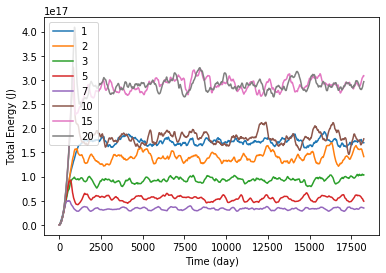

In [31]:
plt.plot(ds.Time/(1e9*3600*24), ds.En.T)
plt.ylabel('Total Energy (J)')
plt.xlabel('Time (day)')
plt.legend(['1', '2','3', '5','7', '10','15', '20'])

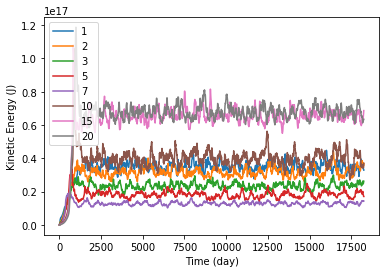

In [32]:
KE = ds.KE.sum('Layer')
plt.plot(ds.Time/(1e9*3600*24), KE.T)
plt.ylabel('Kinetic Energy (J)')
plt.xlabel('Time (day)')
plt.legend(['1', '2','3', '5','7', '10','15', '20'])

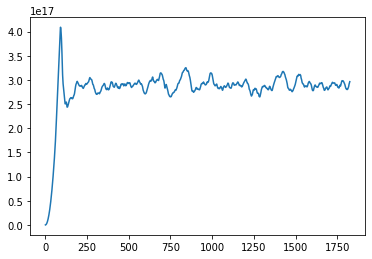

In [33]:
plt.plot(dataset[7].En)

In [23]:
ds.En

<xarray.DataArray 'En' (nr: 4, Time: 1826)>
array([[0.00000000e+00, 3.62496915e+14, 9.06135794e+14, ...,
        1.44074335e+17, 1.42664345e+17, 1.41340727e+17],
       [1.33321739e-09, 2.34921098e+14, 5.13201420e+14, ...,
        4.96440868e+16, 4.94143463e+16, 4.90801264e+16],
       [1.33321739e-09, 1.84329032e+14, 4.05904296e+14, ...,
        1.75563196e+17, 1.76578226e+17, 1.77987402e+17],
       [5.33069542e-09, 1.66463390e+14, 3.74734031e+14, ...,
        3.08760608e+17, 3.08825432e+17, 3.08350922e+17]])
Coordinates:
  * Time     (Time) timedelta64[ns] 0 days 10 days ... 18240 days 18250 days
Dimensions without coordinates: nr
Attributes:
    long_name:  Total Energy
    units:      Joules

# Diagnostics - tranport, stresses

In [35]:
# Read Data
dataset = []
for i in range(0, len(n_ridge)):
    d = xr.open_dataset(ppdir+"H_500_n_"+str(n_ridge[i])+"/prog.nc", chunks={'time': 10})
    #dsgrid = xr.open_dataset(ppdir+"H_500_n_"+n_ridge+"/grid.nc")
    #d = xr.merge([d, dsgrid])
    dataset.append(d)
ds1 = xr.concat(dataset, dim='nr')

#for in range(0,len(n_ridge)):
#    ds_stat = xr.open_dataset(ppdir+"H_500_n_"+n_ridge+"/ocean.stats.nc")
#    ds1 = xr.open_dataset(ppdir+"H_500_n_"+n_ridge+"/prog.nc", chunks={'time': 10})
#    dsgrid = xr.open_dataset(ppdir+"H_500_n_"+n_ridge+"/grid.nc")
#    ds1 = xr.merge([ds1, dsgrid])
#    print(ds1)

OSError: [Errno 5] Input/output error: b'/work/Hemant.Khatri/MOM6_idealised/SWM_Two_Layer/sin_ridge/H_500/H_500_n_1/prog.nc'

In [ ]:
ds1

In [ ]:
# Function for computing mean and eddy transport
def zonal_transport(u, h, grid):
    
    h = grid.interp(h, 'X', boundary='fill')
    
    # compute mean and eddy fields (think about how to define the mean flow)
    um = u.mean('xq')
    hm = h.mean('xq')
    
    ue = u - um
    he = h - hm
    
    # compute transport terms
    umo = (um*hm).mean('Time')
    ueo = (ue*he).mean('Time')
    
    return umo, ueo    


# Function for computing topographic form stress
def topo_form(h, nb, dx, grid, g, rho):
    
    nb_x = grid.diff(nb, 'X', boundary='fill')/dx
    nb_x = - grid.interp(nb_x, 'X', boundary='fill') # minus sign is required because D is depth
    
    TFS = g * ((Topo_x * h).sum('zl')).mean('Time')
    TFS1 = gp * (Topo_x * h.isel(zl=1)).mean('Time')
    
    return TFS, TFS1